<a href="https://colab.research.google.com/github/nicolaiberk/llm_ws/blob/main/notebooks/02_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to embedding manipulation with `gensim`

In [ ]:
!pip install gensim # restart after installation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

## Word Embeddings from Pre-Trained Models

In [ ]:
## we load a 100-dimensional GloVe model trained on Wikipedia data
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100') # small model so we don't have to wait too long...

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
wv['ziti'] # what do our embeddings look like?

array([ 0.049439 ,  0.33049  , -0.62916  ,  0.05941  , -0.070866 ,
       -0.31198  ,  1.0051   , -0.36994  ,  0.51071  ,  0.88759  ,
        0.30675  ,  0.41871  , -0.20705  ,  0.54854  ,  0.2315   ,
       -0.10115  , -0.44656  ,  0.022504 ,  0.31798  ,  0.44769  ,
       -0.50513  ,  0.34741  , -0.069257 ,  0.22331  ,  0.41969  ,
        0.27958  ,  0.0037731, -0.22206  , -0.60191  , -0.67105  ,
        0.1164   ,  0.099292 ,  0.16863  , -0.69876  ,  0.13203  ,
        0.14845  ,  0.020125 , -0.40887  ,  0.15019  , -0.25258  ,
        0.69223  , -0.24897  ,  0.047037 , -0.33101  , -0.16142  ,
        0.10763  , -0.06854  , -0.29817  ,  0.15847  ,  0.92439  ,
        0.52995  ,  0.89365  ,  0.56876  , -0.2421   , -0.78985  ,
        0.75897  ,  0.53027  ,  0.53722  , -0.94077  ,  0.0013162,
       -0.12927  , -0.10485  , -0.059788 , -0.56039  , -0.38289  ,
       -0.43905  ,  0.02313  , -0.27358  , -0.086559 , -0.54393  ,
       -0.49323  ,  0.14044  ,  0.50186  ,  0.11039  , -0.4033

### Get most similar words

In [ ]:
## so what are 'ziti' according to our model? Let's check the most similar embeddings:
print(wv.most_similar(positive=['ziti'], topn=5))

[('rigatoni', 0.7073923349380493), ('penne', 0.6969299912452698), ('focaccia', 0.6311710476875305), ('rotini', 0.6265588402748108), ('scrod', 0.6251025199890137)]


In [ ]:
## you can assess the similarity to other words with the `similarity` function (we'll cover what this score is later today)
wv.similarity('ziti', 'penne')

0.69693005

In [ ]:
# Whereas
wv.similarity('ziti', 'banana')

0.15077041

In [ ]:
# and
wv.similarity('ziti', 'car')

-0.2821738

In [ ]:
## You can calculate with these embeddings:
wv_london = wv['paris'] - wv['france'] + wv['england']
print(wv.most_similar(positive=[wv_london], topn=5))

[('london', 0.7929531931877136), ('england', 0.7346792221069336), ('melbourne', 0.7304184436798096), ('sydney', 0.7011193037033081), ('perth', 0.6856114864349365)]


In [ ]:
## Though it does not always work perfectly
wv_queen = wv['king'] + wv['woman'] - wv['man']
print(wv.most_similar(positive=[wv_queen], topn=5))

[('king', 0.8731269836425781), ('queen', 0.756426215171814), ('monarch', 0.7043204307556152), ('prince', 0.6424739360809326), ('kingdom', 0.6367932558059692)]


In [ ]:
## you can also use the inbuilt function to get weighted averages
print(wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=5))

[('queen', 0.7415665984153748), ('monarch', 0.7021745443344116), ('prince', 0.6327081322669983), ('kingdom', 0.6294623017311096), ('elizabeth', 0.611503005027771)]


In [ ]:
## other cute functions
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


### Train a new model

We'll use an adapted dataset of dialogue in the Simpsons from [Kaggle](https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset?resource=download&select=simpsons_script_lines.csv).

![](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3cHA1dDZ5MWUwOWIyMmd3dHk3MGNyNGdvamEzc2w2dzVjdzdvMW5wOCZlcD12MV9naWZzX3NlYXJjaCZjdD1n/tkYpAbKdWj4TS/giphy.gif)

In [ ]:
## load data
import pandas as pd
dataset = pd.read_csv('https://www.dropbox.com/scl/fi/n5ffxvm4qyjkp8ws7qgoq/simpsons_script_lines_clean.csv?rlkey=gfliitwgi8cqsjxlcdmmdwtym&dl=1')
dataset.head()

,id,raw_character_text,spoken_words
0,9549,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,9550,Lisa Simpson,Where's Mr. Bergstrom?
2,9551,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,9552,Lisa Simpson,That life is worth living.
4,9553,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
## clean the texts (very rough here)
dataset['cleaned_text'] = dataset['spoken_words'].str.replace('[^a-zA-Z \d]','', regex=True) # remove anything that is not a letter or whitespace
dataset['cleaned_text'] = dataset['cleaned_text'].str.lower() # lowercase
dataset['cleaned_text'] = dataset['cleaned_text'].str.replace('\d+', '') # remove multiple whitespaces

In [ ]:
dataset.cleaned_text.head()

,cleaned_text
0,no actually it was a little of both sometimes ...
1,wheres mr bergstrom
2,i dont know although id sure like to talk to h...
3,that life is worth living
4,the polls will be open from now until the end ...


In [ ]:
## filter empty rows and enforce string
dataset = dataset[dataset['cleaned_text'] != '']
dataset.loc[:,'cleaned_text'] = dataset['cleaned_text'].astype(str)

In [ ]:
## how many texts are left?
dataset.shape

(158250, 4)

In [ ]:
## create a list of lists of words by splitting along whitespaces
sentences = [s.split(" ") for s in dataset['cleaned_text']]

In [ ]:
sentences[1]

['wheres', 'mr', 'bergstrom']

In [ ]:
## load dataset (use an iterator for larger datasets: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model)
from gensim.models import Word2Vec

## estimate a model and save
model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # number of dimensions of word embeddings
    window=5,         # number of context words in either direction to include
    min_count=5,      # how often must a word appear to enter the corpus?
    workers=4         # how many CPUs should be used to fit the model?
    )
model.save("simpsons.w2v.model")

In [ ]:
## what is the main output?
model.wv.vectors.shape

In [ ]:
## assess model
model.wv.most_similar('homer', topn=5)

[('bart', 0.8391718864440918),
 ('marge', 0.8391621112823486),
 ('lisa', 0.8119428753852844),
 ('grampa', 0.7085936665534973),
 ('abe', 0.7081788778305054)]

In [ ]:
## subset words of interest
interesting_words = [
    'banana', 'pineapple', 'mango',
    'car', 'bike', 'motorcycle',
    'bart', 'lisa', 'homer']
interesting_vecs = wv[interesting_words]

In [ ]:
## dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(interesting_vecs)
wv_2d = pca.transform(interesting_vecs)
wv_2d = pd.DataFrame(wv_2d, index = interesting_words)

NameError: name 'interesting_vecs' is not defined

In [ ]:
wv_2d

,0,1
banana,3.541008,1.041962
pineapple,4.103635,1.062509
mango,3.847255,0.803713
car,-3.141653,2.390039
bike,-2.633528,1.914495
motorcycle,-2.883574,2.724192
bart,-1.347624,-3.186925
lisa,0.255805,-3.397164
homer,-1.741325,-3.352822


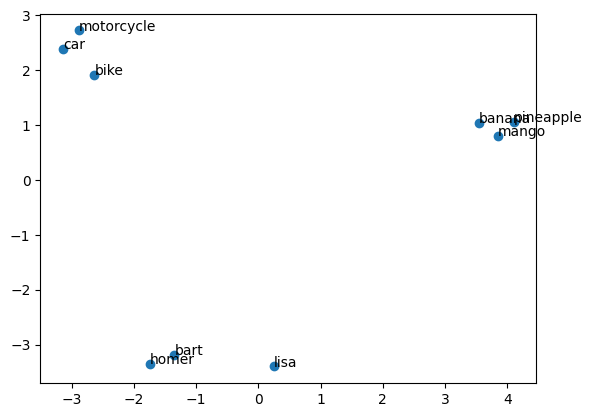

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(wv_2d[0], wv_2d[1])

for i in wv_2d.index:
    plt.annotate(i, (wv_2d[0][i], wv_2d[1][i]))

plt.show()

In [ ]:
## subset words of interest
interesting_words = [
    'paris', 'berlin', 'france', 'germany']
interesting_vecs = wv[interesting_words]

In [ ]:
## dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(interesting_vecs)
wv_2d = pca.transform(interesting_vecs)
wv_2d = pd.DataFrame(wv_2d, index = interesting_words)

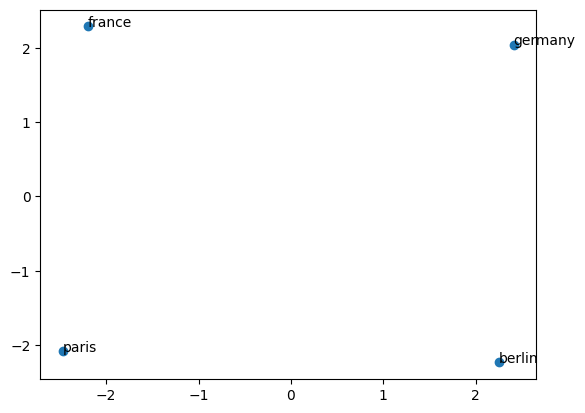

In [ ]:
import matplotlib.pyplot as plt
import random

random.seed(0)

plt.scatter(wv_2d[0], wv_2d[1])

for i in wv_2d.index:
    plt.annotate(i, (wv_2d[0][i], wv_2d[1][i]))

plt.show()

## Exercise

1) Calculate the word vector for Berlin from the vectors for 'paris', 'france', and 'germany'. Explain your reasoning. What does the 

In [ ]:
## your answer

2) Assess the most similar words to this vector. 

In [ ]:
## your answer

3) Plot the calculated vector into the same vector space alongside paris, france, germany, and berlin using PCA.

In [ ]:
## your answer

4) We have trained these embeddings on a dataset from the simpsons, a popular cartoon series. What consequences might this choice of data have for the word embeddings?

**Your answer**

5) Try to find an interesting bias in the data by looking at word similarities